Running on: cpu
Train 50000, Val 10000, Test 10000


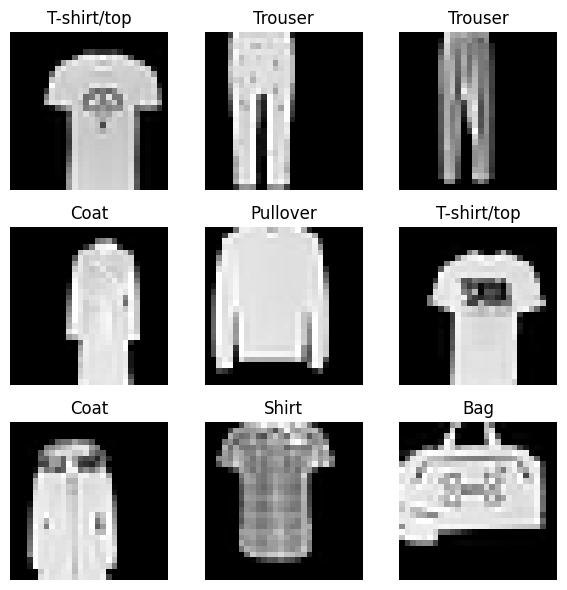


Training SwishMish MLP...
Epoch 01/10 | Train acc 0.648 | Val acc 0.725
Epoch 02/10 | Train acc 0.725 | Val acc 0.750
Epoch 03/10 | Train acc 0.739 | Val acc 0.763
Epoch 04/10 | Train acc 0.752 | Val acc 0.776
Epoch 05/10 | Train acc 0.760 | Val acc 0.782
Epoch 06/10 | Train acc 0.768 | Val acc 0.790
Epoch 07/10 | Train acc 0.774 | Val acc 0.792
Epoch 08/10 | Train acc 0.776 | Val acc 0.801
Epoch 09/10 | Train acc 0.779 | Val acc 0.796
Epoch 10/10 | Train acc 0.781 | Val acc 0.804

Training Deep SwishMish CNN...
Epoch 01/10 | Train acc 0.735 | Val acc 0.814
Epoch 02/10 | Train acc 0.830 | Val acc 0.862


In [ ]:
# ============================================================
# Fashion-MNIST Coursework: ANN vs CNN with Swish & Mish
# ============================================================

# ---- Imports ----
import os, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# ---- Reproducibility and device ----
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# ---- Dataset transforms ----
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

mean, std = (0.5,), (0.5,)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ---- Load Fashion-MNIST ----
data_root = "./data"
train_val = datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform_train)
test_ds   = datasets.FashionMNIST(root=data_root, train=False, download=True, transform=transform_test)

train_size, val_size = 50000, len(train_val) - 50000
train_ds, val_ds = random_split(train_val, [train_size, val_size],
                                generator=torch.Generator().manual_seed(seed))

BATCH_SIZE, NUM_WORKERS = 128, 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train {len(train_ds)}, Val {len(val_ds)}, Test {len(test_ds)}")

# ---- Visual check ----
imgs, lbls = next(iter(train_loader))
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i][0], cmap='gray'); plt.title(class_names[lbls[i]]); plt.axis('off')
plt.tight_layout(); plt.show()

# ============================================================
#                MODEL DEFINITIONS
# ============================================================

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SwishMishMLP(nn.Module):
    def __init__(self, in_size=28*28, h1=512, h2=256, num_classes=10, p_drop=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, num_classes)
        self.drop = nn.Dropout(p_drop)
        self.act1 = Swish()
        self.act2 = Mish()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act1(self.fc1(x))
        x = self.drop(x)
        x = self.act2(self.fc2(x))
        x = self.drop(x)
        return self.fc3(x)

class DeepSwishMishCNN(nn.Module):
    def __init__(self, num_classes=10, p_drop=0.3):
        super().__init__()
        self.act_swish = Swish()
        self.act_mish = Mish()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            self.act_swish,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            self.act_swish,
            nn.MaxPool2d(2),
            nn.Dropout(p_drop),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            self.act_swish,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            self.act_swish,
            nn.MaxPool2d(2),
            nn.Dropout(p_drop),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            self.act_swish,
            nn.MaxPool2d(2),
            nn.Dropout(p_drop)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            self.act_mish,
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

# ============================================================
#                TRAINING UTILITIES
# ============================================================

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward(); optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds, targets = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item() * X.size(0)
            p = out.argmax(1)
            correct += (p == y).sum().item()
            total += y.size(0)
            preds += p.cpu().tolist(); targets += y.cpu().tolist()
    return total_loss / total, correct / total, np.array(preds), np.array(targets)

def train_model(model, train_loader, val_loader, device, lr=1e-3, epochs=10):
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best = 0
    for e in range(1, epochs + 1):
        tl, ta = train_one_epoch(model, train_loader, crit, opt, device)
        vl, va, _, _ = evaluate(model, val_loader, crit, device)
        hist["train_loss"].append(tl); hist["train_acc"].append(ta)
        hist["val_loss"].append(vl);   hist["val_acc"].append(va)
        print(f"Epoch {e:02d}/{epochs} | Train acc {ta:.3f} | Val acc {va:.3f}")
        if va > best: best, best_w = va, model.state_dict().copy()
    model.load_state_dict(best_w)
    return model, hist

# ============================================================
#                TRAIN MODELS
# ============================================================

EPOCHS = 10
LR = 1e-3

print("\nTraining SwishMish MLP...")
mlp = SwishMishMLP().to(device)
mlp, hist_mlp = train_model(mlp, train_loader, val_loader, device, lr=LR, epochs=EPOCHS)

print("\nTraining Deep SwishMish CNN...")
cnn = DeepSwishMishCNN().to(device)
cnn, hist_cnn = train_model(cnn, train_loader, val_loader, device, lr=LR, epochs=EPOCHS)

# ============================================================
#                EVALUATION
# ============================================================

criterion = nn.CrossEntropyLoss()
mlp_loss, mlp_acc, mlp_preds, mlp_targets = evaluate(mlp, test_loader, criterion, device)
cnn_loss, cnn_acc, cnn_preds, cnn_targets = evaluate(cnn, test_loader, criterion, device)

print(f"\nMLP Test Loss: {mlp_loss:.4f}, MLP Test Accuracy: {mlp_acc:.4f}")
print(f"CNN Test Loss: {cnn_loss:.4f}, CNN Test Accuracy: {cnn_acc:.4f}")

# ============================================================
#                VISUALIZATIONS
# ============================================================

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_mlp["train_loss"], label="MLP Train")
plt.plot(hist_mlp["val_loss"], label="MLP Val")
plt.plot(hist_cnn["train_loss"], label="CNN Train")
plt.plot(hist_cnn["val_loss"], label="CNN Val")
plt.title("Loss History"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_mlp["train_acc"], label="MLP Train")
plt.plot(hist_mlp["val_acc"], label="MLP Val")
plt.plot(hist_cnn["train_acc"], label="CNN Train")
plt.plot(hist_cnn["val_acc"], label="CNN Val")
plt.title("Accuracy History"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.show()

# Plot confusion matrix for CNN (as it's expected to perform better)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(cnn_targets, cnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('CNN Confusion Matrix')
plt.show()